In [1]:
from svgpathtools import svg2paths, Path, Line, CubicBezier, QuadraticBezier, Arc
import numpy as np
import csv
from collections import defaultdict
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_points_from_path(path_segment, num_samples=100):
    if isinstance(path_segment, (Line, CubicBezier, QuadraticBezier, Arc)):
        return [path_segment.point(t) for t in np.linspace(0, 1, num_samples)]
    return []

In [3]:
svg_file = './data/problems/frag0.svg' 
paths, _ = svg2paths(svg_file)

all_points = []
for curve_index, path in enumerate(paths):
    for segment in path:
        points = extract_points_from_path(segment)
        all_points.extend([(curve_index, 0.0000, float(p.real), float(p.imag)) for p in points])

with open('out.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['index', 'constant', 'x', 'y'])
    for index, constant, x, y in all_points:
        writer.writerow([index, constant, np.float64(x), np.float64(y)])

In [4]:
curves = defaultdict(list)
with open('out.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  
    for row in reader:
        try:
            curve_no = int(float(row[0])) 
            x = float(row[2])
            y = float(row[3])
            curves[curve_no].append((x, y))
        except ValueError as e:
            print(f"Skipping line due to error: {e}")

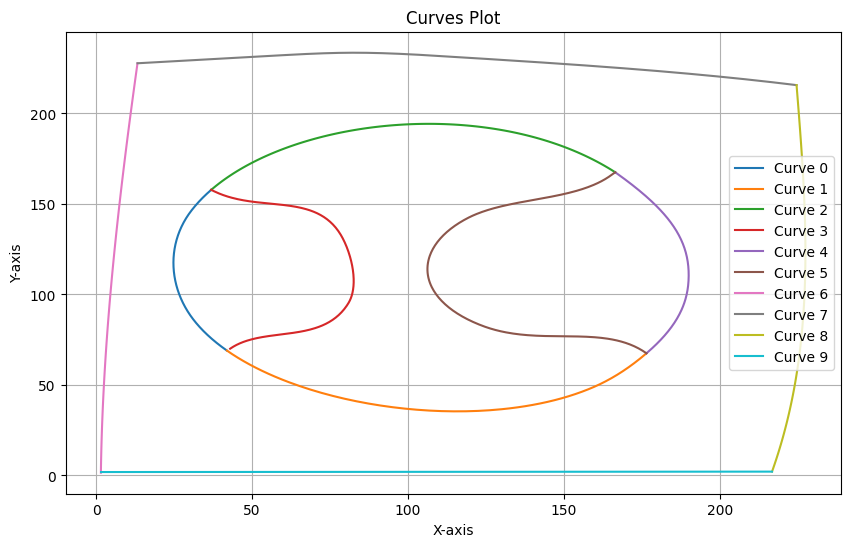

In [5]:
plt.figure(figsize=(10, 6))

for index, points in curves.items():
    x_values, y_values = zip(*points)  # Unpack the list of tuples into two lists: x_values and y_values
    plt.plot(x_values, y_values, label=f'Curve {index}')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Curves Plot')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
curves

defaultdict(list,
            {0: [(41.942, 68.98),
              (41.81014896026895, 69.13892342154325),
              (41.678717852950484, 69.29817831204609),
              (41.54770787767482, 69.45776433759079),
              (41.41712023407218, 69.61768116425968),
              (41.286956121772775, 69.77792845813508),
              (41.157216740406824, 69.93850588529928),
              (41.027903289604545, 70.09941311183461),
              (40.89901696899616, 70.26064980382336),
              (40.770558978211874, 70.42221562734787),
              (40.64253051688191, 70.58411024849042),
              (40.51493278463649, 70.74633333333334),
              (40.38776698110583, 70.90888454795893),
              (40.261034305920134, 71.07176355844952),
              (40.13473595870963, 71.2349700308874),
              (40.008873139104544, 71.39850363135487),
              (39.88344704673508, 71.56236402593429),
              (39.758458881231455, 71.72655088070792),
              (39.63390

In [7]:
import math

def point_line_distance(point, start, end):
    """Calculate the perpendicular distance from a point to a line."""
    if start == end:
        return math.dist(point, start)
    else:
        n = abs((end[1] - start[1]) * point[0] - (end[0] - start[0]) * point[1] + end[0] * start[1] - end[1] * start[0])
        d = math.sqrt((end[1] - start[1]) ** 2 + (end[0] - start[0]) ** 2)
        return n / d

def ramer_douglas_peucker(points, epsilon):
    """Simplify a curve with the Ramer-Douglas-Peucker algorithm."""
    # Find the point with the maximum distance
    dmax = 0.0
    index = 0
    end = len(points)
    for i in range(1, end - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    
    # If max distance is greater than epsilon, recursively simplify
    if dmax > epsilon:
        # Recursive call
        rec_results1 = ramer_douglas_peucker(points[:index+1], epsilon)
        rec_results2 = ramer_douglas_peucker(points[index:], epsilon)
        
        # Build the result list
        result = rec_results1[:-1] + rec_results2
    else:
        result = [points[0], points[-1]]
    
    return result

def simplify_curves(curves, epsilon):
    """Simplify all curves in a dictionary using the Ramer-Douglas-Peucker algorithm."""
    simplified_curves = {}
    inverse_dict = {}
    
    for index, points in curves.items():
        simplified_points = ramer_douglas_peucker(points, epsilon)
        simplified_curves[index] = simplified_points
        
        # Create unique keys for line segments
        for i in range(len(simplified_points) - 1):
            start_point = tuple(simplified_points[i])
            end_point = tuple(simplified_points[i + 1])
            line_key = (start_point, end_point)
            inverse_dict[line_key] = index
    
    return simplified_curves, inverse_dict

epsilon = 1.5
simplified_curves, inverse_dict = simplify_curves(curves, epsilon)
print("Simplified Curves:", simplified_curves)
print("Inverse Dictionary:", inverse_dict)


Simplified Curves: {0: [(41.942, 68.98), (29.961169872379546, 89.02338530288087), (24.91430727023319, 112.62153223593964), (27.209917885105494, 136.88305719164916), (36.89100000000002, 157.80800000000002)], 1: [(176.5, 67.5), (164.715692740073, 53.218744716834706), (151.48993784596294, 43.74154998819951), (133.8674307270233, 37.33333607681756), (114.70817735770106, 35.41459262763334), (95.06009492640925, 37.70259570709648), (74.74404719266943, 44.46135223884598), (56.33590085427268, 55.34165233603251), (41.941999999999894, 68.98000000000002)], 2: [(36.891, 157.808), (48.36266441272227, 171.29351019840274), (63.655899453673555, 182.66043734147925), (81.10363642856481, 190.34020984665548), (99.85842524417731, 194.00945198541888), (119.07281580729239, 193.34478802925688), (136.48421876246394, 188.60492946194924), (152.8986049382716, 179.642392318244), (166.49999999999997, 167.4999999999998)], 3: [(42.964, 70.031), (49.56138241923366, 75.05938467317807), (67.75700650005822, 80.242738753724

In [8]:
import math

def distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def midpoint(point1, point2):
    """Calculate the midpoint between two points."""
    return ((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2)

def round_point(point):
    """Round the coordinates of a point to one decimal place."""
    return (round(point[0], 1), round(point[1], 1))

def update_endpoints_with_midpoints(curves, threshold=1.0):
    """Update endpoints with midpoints if they are very close to each other."""
    endpoints = {}
    updated_curves = {k: v[:] for k, v in curves.items()}  # Create a copy of the curves dictionary

    # Extract endpoints
    for key, points in curves.items():
        endpoints[key] = (points[0], points[-1])

    # Find and update close endpoints
    for key1, (start1, end1) in endpoints.items():
        for key2, (start2, end2) in endpoints.items():
            if key1 < key2:
                if distance(start1, start2) < threshold:
                    mid = midpoint(start1, start2)
                    updated_curves[key1][0] = mid
                    updated_curves[key2][0] = mid
                if distance(start1, end2) < threshold:
                    mid = midpoint(start1, end2)
                    updated_curves[key1][0] = mid
                    updated_curves[key2][-1] = mid
                if distance(end1, start2) < threshold:
                    mid = midpoint(end1, start2)
                    updated_curves[key1][-1] = mid
                    updated_curves[key2][0] = mid
                if distance(end1, end2) < threshold:
                    mid = midpoint(end1, end2)
                    updated_curves[key1][-1] = mid
                    updated_curves[key2][-1] = mid

    # Round all point values in the resulting dictionary
    for key, points in updated_curves.items():
        updated_curves[key] = [round_point(point) for point in points]

    return updated_curves

def update_inverse_dict(curves, inverse_dict, threshold=1.0):
    """Update the inverse dictionary with the new curve endpoints."""
    new_inverse_dict = {}
    
    # Recreate the inverse dictionary based on updated curves
    for index, points in curves.items():
        for i in range(len(points) - 1):
            start_point = tuple(points[i])
            end_point = tuple(points[i + 1])
            line_key = (start_point, end_point)
            new_inverse_dict[line_key] = index
    
    return new_inverse_dict


epsilon = 1.5
simplified_curves, inverse_dict = simplify_curves(curves, epsilon)

threshold = 5.0
updated_curves = update_endpoints_with_midpoints(simplified_curves, threshold)
new_inverse_dict = update_inverse_dict(updated_curves, inverse_dict, threshold)

print("Updated Curves:", updated_curves)
print("New Inverse Dictionary:", new_inverse_dict)
inverse_dict = new_inverse_dict


Updated Curves: {0: [(42.5, 69.5), (30.0, 89.0), (24.9, 112.6), (27.2, 136.9), (36.9, 157.8)], 1: [(176.5, 67.5), (164.7, 53.2), (151.5, 43.7), (133.9, 37.3), (114.7, 35.4), (95.1, 37.7), (74.7, 44.5), (56.3, 55.3), (42.5, 69.5)], 2: [(36.9, 157.8), (48.4, 171.3), (63.7, 182.7), (81.1, 190.3), (99.9, 194.0), (119.1, 193.3), (136.5, 188.6), (152.9, 179.6), (166.5, 167.5)], 3: [(42.5, 69.5), (49.6, 75.1), (67.8, 80.2), (75.1, 85.1), (81.4, 96.7), (82.4, 112.3), (78.8, 132.0), (72.3, 143.6), (64.5, 148.3), (44.9, 152.8), (36.9, 157.8)], 4: [(166.5, 167.5), (183.0, 142.7), (189.7, 118.8), (187.8, 91.8), (176.5, 67.5)], 5: [(176.5, 67.5), (164.5, 75.4), (136.6, 77.8), (124.7, 82.2), (111.9, 94.6), (106.4, 110.6), (108.7, 127.2), (118.5, 141.6), (128.6, 148.1), (155.5, 158.0), (166.5, 167.5)], 6: [(13.2, 227.8), (4.8, 104.4), (1.5, 1.7)], 7: [(224.6, 215.7), (170.1, 224.9), (92.6, 233.3), (13.2, 227.8)], 8: [(216.8, 2.1), (223.5, 44.8), (226.9, 92.1), (224.6, 215.7)], 9: [(1.5, 1.7), (216.8,

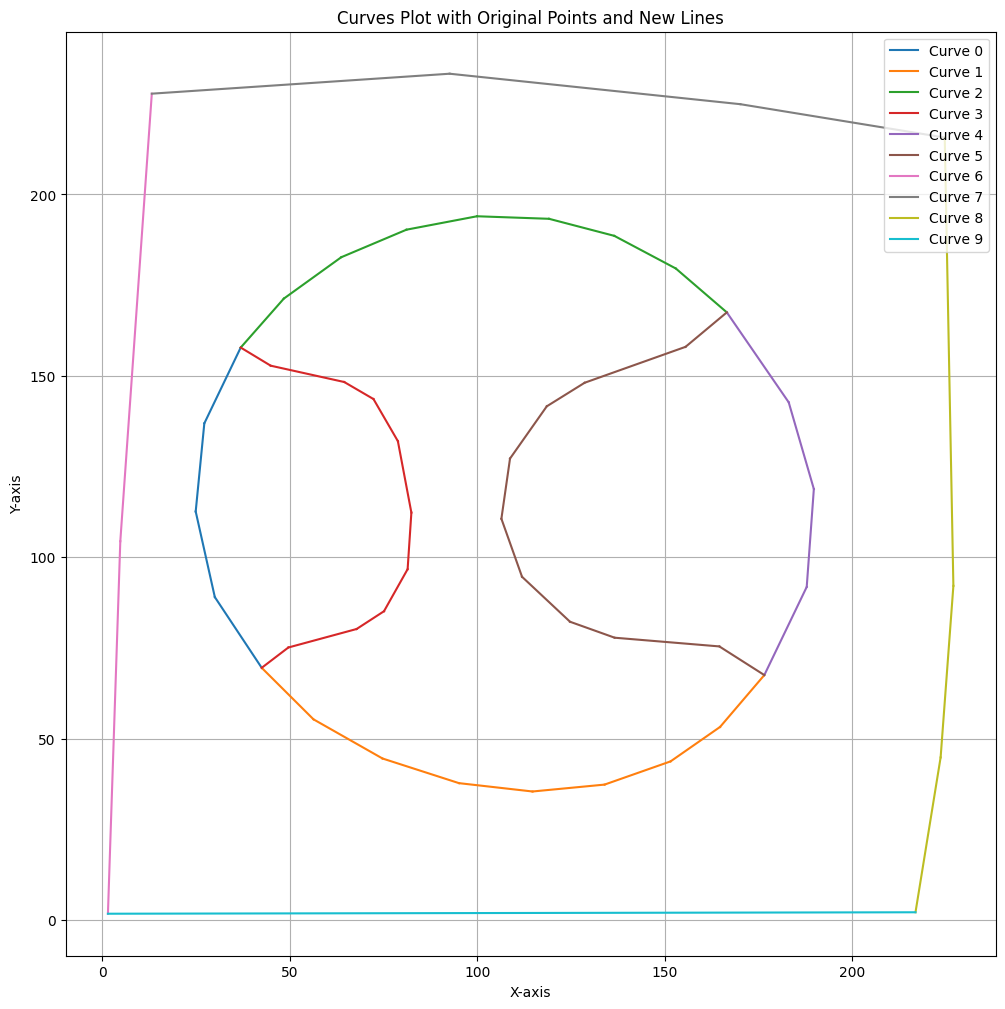

In [9]:
import matplotlib.pyplot as plt


curve_colors = {}
for line_key, curve_num in inverse_dict.items():
    if curve_num not in curve_colors:
        curve_colors[curve_num] = plt.cm.tab10(len(curve_colors))  

plt.figure(figsize=(12, 12))

for index, points in curves.items():
    x_values, y_values = zip(*points)  
    # plt.scatter(x_values, y_values, label=f'Original Points Curve {index}',linestyle='--')

for line_key, curve_num in inverse_dict.items():
    start, end = line_key
    color = curve_colors[curve_num]
    plt.plot([start[0], end[0]], [start[1], end[1]], color=color, label=f'Curve {curve_num}' if f'Curve {curve_num}' not in plt.gca().get_legend_handles_labels()[1] else "", linestyle='-')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Curves Plot with Original Points and New Lines')
plt.legend()
plt.grid(True)
plt.show()


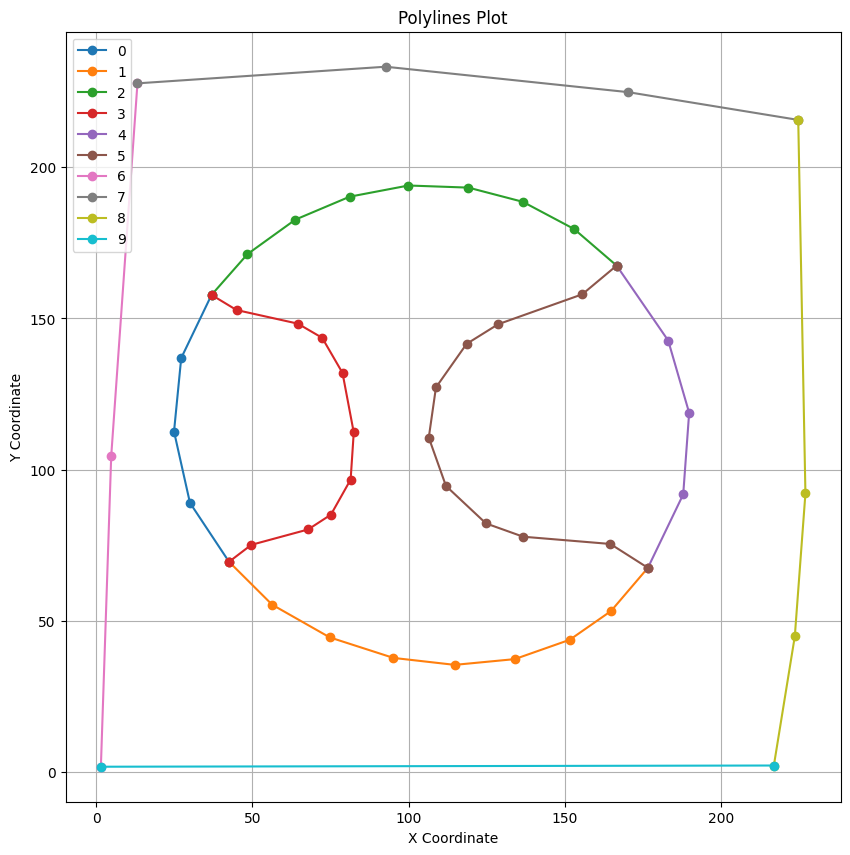

In [10]:
plt.figure(figsize=(10, 10))

for label, points in updated_curves.items():
    xs, ys = zip(*points)  # Unzip the list of points into x and y coordinates
    plt.plot(xs, ys, marker='o', label=label)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Polylines Plot')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from collections import defaultdict

# Initialize adjacency list as a defaultdict of lists
adj_list = defaultdict(list)

# Given polylines


# Populate the adjacency list
for polyline in updated_curves.values():
    for i in range(len(polyline) - 1):
        start, end = polyline[i], polyline[i+1]
        adj_list[start].append(end)
        adj_list[end].append(start)

# Convert to a regular dictionary for a nicer display
adj_list = dict(adj_list)
adj_list

{(42.5, 69.5): [(30.0, 89.0), (56.3, 55.3), (49.6, 75.1)],
 (30.0, 89.0): [(42.5, 69.5), (24.9, 112.6)],
 (24.9, 112.6): [(30.0, 89.0), (27.2, 136.9)],
 (27.2, 136.9): [(24.9, 112.6), (36.9, 157.8)],
 (36.9, 157.8): [(27.2, 136.9), (48.4, 171.3), (44.9, 152.8)],
 (176.5, 67.5): [(164.7, 53.2), (187.8, 91.8), (164.5, 75.4)],
 (164.7, 53.2): [(176.5, 67.5), (151.5, 43.7)],
 (151.5, 43.7): [(164.7, 53.2), (133.9, 37.3)],
 (133.9, 37.3): [(151.5, 43.7), (114.7, 35.4)],
 (114.7, 35.4): [(133.9, 37.3), (95.1, 37.7)],
 (95.1, 37.7): [(114.7, 35.4), (74.7, 44.5)],
 (74.7, 44.5): [(95.1, 37.7), (56.3, 55.3)],
 (56.3, 55.3): [(74.7, 44.5), (42.5, 69.5)],
 (48.4, 171.3): [(36.9, 157.8), (63.7, 182.7)],
 (63.7, 182.7): [(48.4, 171.3), (81.1, 190.3)],
 (81.1, 190.3): [(63.7, 182.7), (99.9, 194.0)],
 (99.9, 194.0): [(81.1, 190.3), (119.1, 193.3)],
 (119.1, 193.3): [(99.9, 194.0), (136.5, 188.6)],
 (136.5, 188.6): [(119.1, 193.3), (152.9, 179.6)],
 (152.9, 179.6): [(136.5, 188.6), (166.5, 167.5)],
 (

In [12]:
from collections import defaultdict

def find_cycles(graph):
    def dfs(node, start, visited, path):
        visited[node] = True
        path.append(node)
        
        for neighbor in graph[node]:
            if neighbor == start and len(path) > 2:
                # Found a cycle
                cycle = path[:] + [start]
                cycles.append(cycle)
            elif not visited[neighbor]:
                dfs(neighbor, start, visited, path)
        
        path.pop()
        visited[node] = False

    cycles = []
    visited = defaultdict(bool)
    
    for node in graph:
        if not visited[node]:
            dfs(node, node, visited, [])
    
    unique_cycles = []
    for cycle in cycles:
        cycle_set = set(cycle)
        if all(cycle_set != set(c) for c in unique_cycles):
            unique_cycles.append(cycle)
    
    return unique_cycles


# Finding unique cycles
unique_cycles = find_cycles(adj_list)

# Display the unique cycles
for cycle in unique_cycles:
    print(cycle)
unique_cycles

[(42.5, 69.5), (30.0, 89.0), (24.9, 112.6), (27.2, 136.9), (36.9, 157.8), (48.4, 171.3), (63.7, 182.7), (81.1, 190.3), (99.9, 194.0), (119.1, 193.3), (136.5, 188.6), (152.9, 179.6), (166.5, 167.5), (183.0, 142.7), (189.7, 118.8), (187.8, 91.8), (176.5, 67.5), (164.7, 53.2), (151.5, 43.7), (133.9, 37.3), (114.7, 35.4), (95.1, 37.7), (74.7, 44.5), (56.3, 55.3), (42.5, 69.5)]
[(42.5, 69.5), (30.0, 89.0), (24.9, 112.6), (27.2, 136.9), (36.9, 157.8), (48.4, 171.3), (63.7, 182.7), (81.1, 190.3), (99.9, 194.0), (119.1, 193.3), (136.5, 188.6), (152.9, 179.6), (166.5, 167.5), (155.5, 158.0), (128.6, 148.1), (118.5, 141.6), (108.7, 127.2), (106.4, 110.6), (111.9, 94.6), (124.7, 82.2), (136.6, 77.8), (164.5, 75.4), (176.5, 67.5), (164.7, 53.2), (151.5, 43.7), (133.9, 37.3), (114.7, 35.4), (95.1, 37.7), (74.7, 44.5), (56.3, 55.3), (42.5, 69.5)]
[(42.5, 69.5), (30.0, 89.0), (24.9, 112.6), (27.2, 136.9), (36.9, 157.8), (44.9, 152.8), (64.5, 148.3), (72.3, 143.6), (78.8, 132.0), (82.4, 112.3), (81.4,

[[(42.5, 69.5),
  (30.0, 89.0),
  (24.9, 112.6),
  (27.2, 136.9),
  (36.9, 157.8),
  (48.4, 171.3),
  (63.7, 182.7),
  (81.1, 190.3),
  (99.9, 194.0),
  (119.1, 193.3),
  (136.5, 188.6),
  (152.9, 179.6),
  (166.5, 167.5),
  (183.0, 142.7),
  (189.7, 118.8),
  (187.8, 91.8),
  (176.5, 67.5),
  (164.7, 53.2),
  (151.5, 43.7),
  (133.9, 37.3),
  (114.7, 35.4),
  (95.1, 37.7),
  (74.7, 44.5),
  (56.3, 55.3),
  (42.5, 69.5)],
 [(42.5, 69.5),
  (30.0, 89.0),
  (24.9, 112.6),
  (27.2, 136.9),
  (36.9, 157.8),
  (48.4, 171.3),
  (63.7, 182.7),
  (81.1, 190.3),
  (99.9, 194.0),
  (119.1, 193.3),
  (136.5, 188.6),
  (152.9, 179.6),
  (166.5, 167.5),
  (155.5, 158.0),
  (128.6, 148.1),
  (118.5, 141.6),
  (108.7, 127.2),
  (106.4, 110.6),
  (111.9, 94.6),
  (124.7, 82.2),
  (136.6, 77.8),
  (164.5, 75.4),
  (176.5, 67.5),
  (164.7, 53.2),
  (151.5, 43.7),
  (133.9, 37.3),
  (114.7, 35.4),
  (95.1, 37.7),
  (74.7, 44.5),
  (56.3, 55.3),
  (42.5, 69.5)],
 [(42.5, 69.5),
  (30.0, 89.0),
  (24.9, 11

In [13]:
def point_to_segment_dist(p, v, w):
    l2 = np.sum((v - w) ** 2)
    if l2 == 0:
        return np.sum((p - v) ** 2)
    t = max(0, min(1, np.dot(p - v, w - v) / l2))
    projection = v + t * (w - v)
    return np.sum((p - projection) ** 2)

def mean_square_fitting_error(polygon, square_vertices):
    total_error = 0
    for point in polygon:
        min_dist = float('inf')
        for i in range(len(square_vertices)):
            segment_start = square_vertices[i]
            segment_end = square_vertices[(i + 1) % len(square_vertices)]
            dist = point_to_segment_dist(point, segment_start, segment_end)
            if dist < min_dist:
                min_dist = dist
        total_error += min_dist
    mse = total_error / len(polygon)
    return mse

def best_fit_square(polygon):
    # Convert polygon to numpy array for easier manipulation
    polygon = np.array(polygon)
    
    # Calculate the axis-aligned bounding box of the polygon
    min_x, min_y = np.min(polygon, axis=0)
    max_x, max_y = np.max(polygon, axis=0)
    
    # Calculate the center of the bounding box
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    
    # Determine the side length of the square
    width = max_x - min_x
    height = max_y - min_y
    side_length = max(width, height)
    
    # Create the vertices of the axis-aligned square
    half_side = side_length / 2
    square_vertices = np.array([
        [center_x - half_side, center_y - half_side],
        [center_x + half_side, center_y - half_side],
        [center_x + half_side, center_y + half_side],
        [center_x - half_side, center_y + half_side],
    ])
    
    # Calculate the mean square fitting error
    mse = mean_square_fitting_error(polygon, square_vertices)
    return mse, square_vertices

# Example polygon vertices
polygon = unique_cycles[6]

best_fit_square(polygon)


(np.float64(25.32000000000002),
 array([[ -1.6,   1.7],
        [230. ,   1.7],
        [230. , 233.3],
        [ -1.6, 233.3]]))

Mean Square Fitting Error: 12.1515


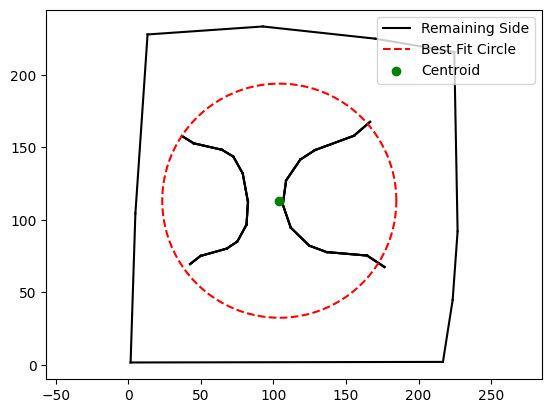

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

def mean_square_circle_error(polygon, center, radius):
    total_error = 0
    for point in polygon:
        dist = np.linalg.norm(point - center)
        error = (dist - radius) ** 2
        total_error += error
    mse = total_error / len(polygon)
    return mse

def best_fit_circle(polygon):
    polygon = np.array(polygon)  
    
    centroid = np.mean(polygon, axis=0)  
    distances = np.linalg.norm(polygon - centroid, axis=1)  
    radius = np.mean(distances)  
    mse = mean_square_circle_error(polygon, centroid, radius)  
    
    return centroid, radius, mse

def plot_polygon_and_circle(polygon, centroid, radius, label):
    polygon = np.array(polygon)  # Ensure polygon is a numpy array
    theta = np.linspace(0, 2 * np.pi, 100)
    circle_x = centroid[0] + radius * np.cos(theta)
    circle_y = centroid[1] + radius * np.sin(theta)
    
    # plt.plot(*polygon.T, 'b-', label='Polygon')
    plt.plot(circle_x, circle_y, 'r--', label=label)
    plt.scatter(*centroid, color='green', zorder=5, label='Centroid')

def plot_remaining_sides(unique_cycles, marked_sides):
    for polygon in unique_cycles:
        polygon = np.array(polygon)
        for i in range(len(polygon)):
            side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
            if side not in marked_sides:
                plt.plot(*np.array([polygon[i], polygon[(i + 1) % len(polygon)]]).T, 'k-', label='Remaining Side' if i == 0 else "")

min_heap = []
possible_circles = []
unused_loops = []

for polygon in unique_cycles:
    centroid, radius, mse = best_fit_circle(polygon)
    heapq.heappush(min_heap, (mse, centroid, radius, polygon))

marked_sides = set()

while min_heap:
    mse, centroid, radius, polygon = heapq.heappop(min_heap)
    
    contains_marked_side = False
    for i in range(len(polygon)):
        side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
        if side in marked_sides:
            contains_marked_side = True
            break
    
    if contains_marked_side:
        unused_loops.append(polygon)
        continue
    
    if mse < 25:
        print(f'Mean Square Fitting Error: {mse:.4f}')
        possible_circles.append((centroid, radius, polygon))
        # plot_polygon_and_circle(polygon, centroid, radius, label='Best Fit Circle')
        
        for i in range(len(polygon)):
            side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
            marked_sides.add(side)
    else:
        unused_loops.append(polygon)

for polygon in unique_cycles:
    for i in range(len(polygon)):
        side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))


filtered_unused_loops = []
for loop in unused_loops:
    all_sides_unused = True
    for i in range(len(loop)):
        side = tuple(sorted([tuple(loop[i]), tuple(loop[(i + 1) % len(loop)])]))
        if side in marked_sides:
            all_sides_unused = False
            break
    if all_sides_unused:
        filtered_unused_loops.append(loop)

plt.figure()

plot_remaining_sides(unique_cycles, marked_sides)

for centroid, radius, polygon in possible_circles:
    plot_polygon_and_circle(polygon, centroid, radius, label='Best Fit Circle')

plt.legend()
plt.axis('equal')
plt.show()



In [15]:
import matplotlib.pyplot as plt

def plot_curves_from_sides(curves, inverse_dict, remaining_sides):
    """Plot curves based on the remaining sides and their corresponding curves."""
    
    plt.figure(figsize=(12, 8))
    
    plotted_curves = set()
    
    for side in remaining_sides:
        if side in inverse_dict:
            curve_num = inverse_dict[side]
            if curve_num not in plotted_curves:
                if curve_num in curves:
                    points = curves[curve_num]
                    x_values, y_values = zip(*points)
                    plt.plot(x_values, y_values, label=f'Curve {curve_num}')
                    plotted_curves.add(curve_num)
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Curves Based on Remaining Sides')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
# plot_curves_from_sides(curves, inverse_dict, remaining_sides)
